/tmp/ipython-input-3984591526.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col])


Data Preview:
            prices
dates             
2020-10-31    10.1
2020-11-30    10.3
2020-12-31    11.0
2021-01-31    10.9
2021-02-28    10.9


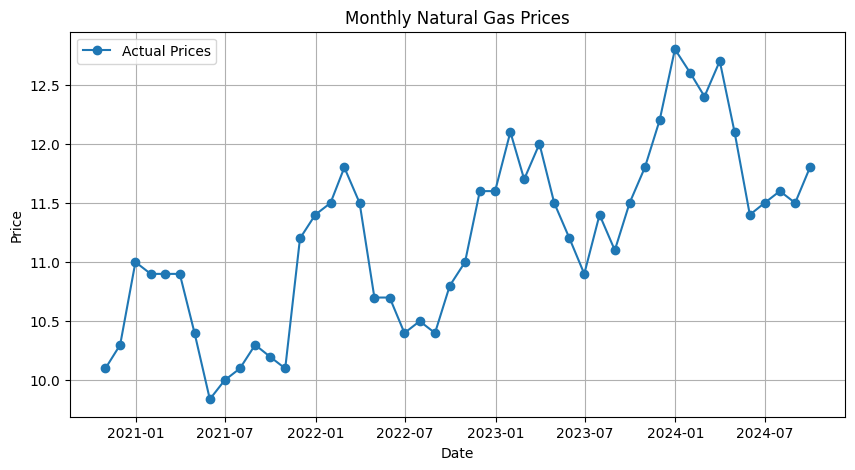

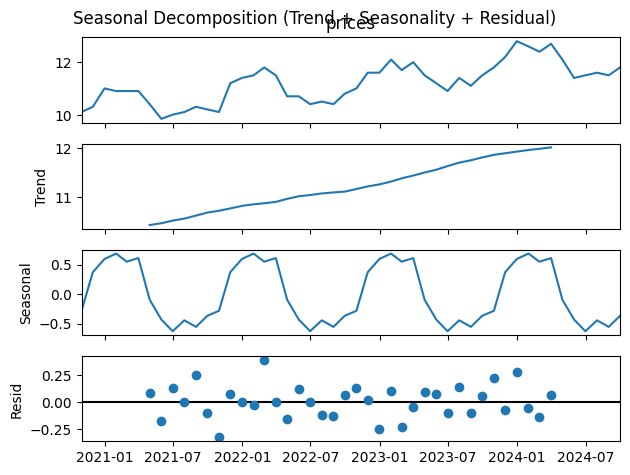

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                             prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   1.581
Date:                            Sat, 25 Oct 2025   AIC                              6.838
Time:                                    19:27:18   BIC                             12.061
Sample:                                10-31-2020   HQIC                             7.972
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4532      0.301     -1.505      0.132      -1.044       0.137
ma.L1         -0.5152      0.344   

/tmp/ipython-input-3984591526.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')


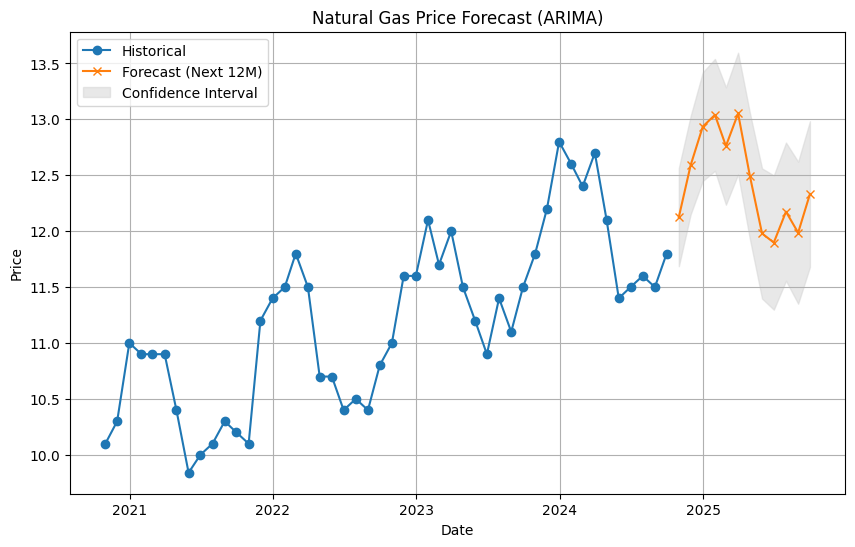

Estimated price for 2025-05-31: 11.98


In [2]:
# ============================================
# Natural Gas Price Estimation with ARIMA
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1️⃣ Load and inspect data
file_path = "Nat_Gas.csv"  # update if needed
df = pd.read_csv(file_path)

# Normalize column names
df.columns = [c.strip().lower() for c in df.columns]
date_col = [c for c in df.columns if 'date' in c or 'month' in c][0]
price_col = [c for c in df.columns if 'price' in c][0]

# Convert date column
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col)
df.set_index(date_col, inplace=True)

print("Data Preview:")
print(df.head())

# 2️⃣ Visualize raw data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df[price_col], marker='o', label='Actual Prices')
plt.title("Monthly Natural Gas Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

# 3️⃣ Seasonal Decomposition
decomposition = sm.tsa.seasonal_decompose(df[price_col], model='additive', period=12)
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Trend + Seasonality + Residual)")
plt.show()

# 4️⃣ Fit ARIMA (auto ARIMA logic)
# We'll use SARIMAX for seasonal component (seasonal order = (1,1,1,12))
model = SARIMAX(df[price_col],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

# 5️⃣ Forecast for next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Combine data
forecast_df = pd.DataFrame({
    'date': forecast_index,
    'forecast_price': forecast_mean.values
}).set_index('date')

# 6️⃣ Plot Forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[price_col], label='Historical', marker='o')
plt.plot(forecast_df.index, forecast_df['forecast_price'], label='Forecast (Next 12M)', marker='x')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='lightgray', alpha=0.5, label='Confidence Interval')
plt.title("Natural Gas Price Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# 7️⃣ Function to estimate price for any date
def estimate_price(date_str):
    """
    Estimate natural gas price for any given date using ARIMA model.
    """
    input_date = pd.to_datetime(date_str)
    last_date = df.index[-1]

    # Case 1: date is before last known data
    if input_date <= last_date:
        # Find closest historical month
        closest_date = df.index[df.index.get_indexer([input_date], method='nearest')[0]]
        return round(df.loc[closest_date, price_col], 2)

    # Case 2: date is in the future (forecast)
    months_ahead = (input_date.year - last_date.year) * 12 + (input_date.month - last_date.month)
    if months_ahead <= 0:
        months_ahead = 1

    forecast_future = results.get_forecast(steps=months_ahead)
    predicted_price = forecast_future.predicted_mean.iloc[-1]
    return round(predicted_price, 2)


# Example usage
print("Estimated price for 2025-05-31:", estimate_price("2025-05-31"))
